# Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error

import scipy

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('ggplot')

In [3]:
RANDOM_SEED = 42

## Loading Data

In [4]:
raw_df = pd.read_csv(r"pollution_us_2000_2016.csv")

In [5]:
df = raw_df.copy()

In [6]:
df

,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.200,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.200,23,25.0
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.200,21,NaN
3,3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.200,23,25.0
4,4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,...,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.600,23,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746656,24599,56,21,100,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,2016-03-30,Parts per billion,...,Parts per billion,0.000000,0.0,2,NaN,Parts per million,0.091667,0.100,2,1.0
1746657,24600,56,21,100,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,2016-03-31,Parts per billion,...,Parts per billion,-0.022727,0.0,0,0.0,Parts per million,0.067714,0.127,0,NaN
1746658,24601,56,21,100,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,2016-03-31,Parts per billion,...,Parts per billion,-0.022727,0.0,0,0.0,Parts per million,0.100000,0.100,0,1.0
1746659,24602,56,21,100,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,2016-03-31,Parts per billion,...,Parts per billion,0.000000,0.0,5,NaN,Parts per million,0.067714,0.127,0,NaN


**AQI:** It is a system that informs the public about air pollution levels. It tracks particle pollution and ozone (smog), as well as other widespread air pollutants. Lower the index better Air Quality.

### EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1746661 entries, 0 to 1746660
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   State Code         int64  
 2   County Code        int64  
 3   Site Num           int64  
 4   Address            object 
 5   State              object 
 6   County             object 
 7   City               object 
 8   Date Local         object 
 9   NO2 Units          object 
 10  NO2 Mean           float64
 11  NO2 1st Max Value  float64
 12  NO2 1st Max Hour   int64  
 13  NO2 AQI            int64  
 14  O3 Units           object 
 15  O3 Mean            float64
 16  O3 1st Max Value   float64
 17  O3 1st Max Hour    int64  
 18  O3 AQI             int64  
 19  SO2 Units          object 
 20  SO2 Mean           float64
 21  SO2 1st Max Value  float64
 22  SO2 1st Max Hour   int64  
 23  SO2 AQI            float64
 24  CO Units           object 
 25  CO Mean           

In [8]:
df.describe(include="all")

,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
count,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1746661,1746661,1746661,1746661,1746661,1746661,...,1746661,1.746661e+06,1.746661e+06,1.746661e+06,873754.000000,1746661,1.746661e+06,1.746661e+06,1.746661e+06,873338.000000
unique,NaN,NaN,NaN,NaN,204,47,133,144,5996,1,...,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,PIKE AVE AT RIVER ROAD,California,Los Angeles,Not in a city,2002-06-10,Parts per billion,...,Parts per billion,NaN,NaN,NaN,NaN,Parts per million,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,35332,576142,93381,138411,640,1746661,...,1746661,NaN,NaN,NaN,NaN,1746661,NaN,NaN,NaN,NaN
mean,5.471414e+04,2.230907e+01,7.169381e+01,1.118214e+03,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.870364e+00,4.492185e+00,9.664906e+00,7.115945,NaN,3.682177e-01,6.201067e-01,7.875026e+00,5.996595
std,3.372908e+04,1.725621e+01,7.948023e+01,2.003103e+03,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.760435e+00,7.679866e+00,6.731228e+00,11.937473,NaN,3.140231e-01,6.439361e-01,7.978844e+00,5.851836
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.000000e+00,-2.000000e+00,0.000000e+00,0.000000,NaN,-4.375000e-01,-4.000000e-01,0.000000e+00,0.000000
25%,2.575300e+04,6.000000e+00,1.700000e+01,9.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.565220e-01,8.000000e-01,5.000000e+00,1.000000,NaN,1.834580e-01,2.920000e-01,0.000000e+00,2.000000
50%,5.304500e+04,1.700000e+01,5.900000e+01,6.000000e+01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.875000e-01,2.000000e+00,8.000000e+00,3.000000,NaN,2.926250e-01,4.000000e-01,6.000000e+00,5.000000
75%,8.033600e+04,4.000000e+01,9.700000e+01,1.039000e+03,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.325000e+00,5.000000e+00,1.400000e+01,9.000000,NaN,4.666670e-01,8.000000e-01,1.300000e+01,8.000000


In [9]:
object_columns = df.select_dtypes(include='object')

In [10]:
object_columns

,Address,State,County,City,Date Local,NO2 Units,O3 Units,SO2 Units,CO Units
0,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,Parts per million,Parts per billion,Parts per million
1,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,Parts per million,Parts per billion,Parts per million
2,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,Parts per million,Parts per billion,Parts per million
3,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,Parts per million,Parts per billion,Parts per million
4,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,Parts per million,Parts per billion,Parts per million
...,...,...,...,...,...,...,...,...,...
1746656,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,2016-03-30,Parts per billion,Parts per million,Parts per billion,Parts per million
1746657,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,2016-03-31,Parts per billion,Parts per million,Parts per billion,Parts per million
1746658,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,2016-03-31,Parts per billion,Parts per million,Parts per billion,Parts per million
1746659,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,2016-03-31,Parts per billion,Parts per million,Parts per billion,Parts per million


In [11]:
object_columns.describe()

,Address,State,County,City,Date Local,NO2 Units,O3 Units,SO2 Units,CO Units
count,1746661,1746661,1746661,1746661,1746661,1746661,1746661,1746661,1746661
unique,204,47,133,144,5996,1,1,1,1
top,PIKE AVE AT RIVER ROAD,California,Los Angeles,Not in a city,2002-06-10,Parts per billion,Parts per million,Parts per billion,Parts per million
freq,35332,576142,93381,138411,640,1746661,1746661,1746661,1746661


In [12]:
object_columns_list = list(object_columns.columns)
object_columns_list

['Address',
 'State',
 'County',
 'City',
 'Date Local',
 'NO2 Units',
 'O3 Units',
 'SO2 Units',
 'CO Units']

In [13]:
non_object_columns = df.select_dtypes(exclude='object')

In [14]:
non_object_columns.describe()

,Unnamed: 0,State Code,County Code,Site Num,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
count,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,1.746661e+06,873754.000000,1.746661e+06,1.746661e+06,1.746661e+06,873338.000000
mean,5.471414e+04,2.230907e+01,7.169381e+01,1.118214e+03,1.282193e+01,2.541485e+01,1.173102e+01,2.389822e+01,2.612485e-02,3.920331e-02,1.017053e+01,3.605012e+01,1.870364e+00,4.492185e+00,9.664906e+00,7.115945,3.682177e-01,6.201067e-01,7.875026e+00,5.996595
std,3.372908e+04,1.725621e+01,7.948023e+01,2.003103e+03,9.504814e+00,1.599963e+01,7.877501e+00,1.516280e+01,1.136974e-02,1.534362e-02,4.003144e+00,1.978042e+01,2.760435e+00,7.679866e+00,6.731228e+00,11.937473,3.140231e-01,6.439361e-01,7.978844e+00,5.851836
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,-2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00,-2.000000e+00,0.000000e+00,0.000000,-4.375000e-01,-4.000000e-01,0.000000e+00,0.000000
25%,2.575300e+04,6.000000e+00,1.700000e+01,9.000000e+00,5.750000e+00,1.300000e+01,5.000000e+00,1.200000e+01,1.787500e-02,2.900000e-02,9.000000e+00,2.500000e+01,2.565220e-01,8.000000e-01,5.000000e+00,1.000000,1.834580e-01,2.920000e-01,0.000000e+00,2.000000
50%,5.304500e+04,1.700000e+01,5.900000e+01,6.000000e+01,1.073913e+01,2.400000e+01,9.000000e+00,2.300000e+01,2.587500e-02,3.800000e-02,1.000000e+01,3.300000e+01,9.875000e-01,2.000000e+00,8.000000e+00,3.000000,2.926250e-01,4.000000e-01,6.000000e+00,5.000000
75%,8.033600e+04,4.000000e+01,9.700000e+01,1.039000e+03,1.771364e+01,3.570000e+01,2.000000e+01,3.300000e+01,3.391700e-02,4.800000e-02,1.100000e+01,4.200000e+01,2.325000e+00,5.000000e+00,1.400000e+01,9.000000,4.666670e-01,8.000000e-01,1.300000e+01,8.000000
max,1.345750e+05,8.000000e+01,6.500000e+02,9.997000e+03,1.395417e+02,2.670000e+02,2.300000e+01,1.320000e+02,9.508300e-02,1.410000e-01,2.300000e+01,2.180000e+02,3.216250e+02,3.510000e+02,2.300000e+01,200.000000,7.508333e+00,1.990000e+01,2.300000e+01,201.000000


In [15]:
non_object_columns_list = list(non_object_columns.columns)
non_object_columns_list

['Unnamed: 0',
 'State Code',
 'County Code',
 'Site Num',
 'NO2 Mean',
 'NO2 1st Max Value',
 'NO2 1st Max Hour',
 'NO2 AQI',
 'O3 Mean',
 'O3 1st Max Value',
 'O3 1st Max Hour',
 'O3 AQI',
 'SO2 Mean',
 'SO2 1st Max Value',
 'SO2 1st Max Hour',
 'SO2 AQI',
 'CO Mean',
 'CO 1st Max Value',
 'CO 1st Max Hour',
 'CO AQI']

#### Removing unnecessary columns

In [16]:
columns_to_be_removed = ["Unnamed: 0",
                         'Address',
                         'NO2 Units', 
                         'O3 Units', 
                         'SO2 Units', 
                         'CO Units']

**Reason for selecting these columns:**
- `Unnamed: 0` : Contains random numbers. (Unnecessary data)
- `Address` : Specific address of the sensors. (Address is already split into city, county and state)
- `NO2 Units`, `O3 Units`, `SO2 Units`, `CO Units` : Units for measuring AQI. (Created a common unit column)

In [17]:
treated_df = df.drop(columns_to_be_removed, axis=1)

In [18]:
treated_df

,State Code,County Code,Site Num,State,County,City,Date Local,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,...,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,4,13,3002,Arizona,Maricopa,Phoenix,2000-01-01,19.041667,49.0,19,...,10,34,3.000000,9.0,21,13.0,1.145833,4.200,21,NaN
1,4,13,3002,Arizona,Maricopa,Phoenix,2000-01-01,19.041667,49.0,19,...,10,34,3.000000,9.0,21,13.0,0.878947,2.200,23,25.0
2,4,13,3002,Arizona,Maricopa,Phoenix,2000-01-01,19.041667,49.0,19,...,10,34,2.975000,6.6,23,NaN,1.145833,4.200,21,NaN
3,4,13,3002,Arizona,Maricopa,Phoenix,2000-01-01,19.041667,49.0,19,...,10,34,2.975000,6.6,23,NaN,0.878947,2.200,23,25.0
4,4,13,3002,Arizona,Maricopa,Phoenix,2000-01-02,22.958333,36.0,19,...,10,27,1.958333,3.0,22,4.0,0.850000,1.600,23,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746656,56,21,100,Wyoming,Laramie,Not in a city,2016-03-30,1.083333,1.6,9,...,18,44,0.000000,0.0,2,NaN,0.091667,0.100,2,1.0
1746657,56,21,100,Wyoming,Laramie,Not in a city,2016-03-31,0.939130,1.3,5,...,9,44,-0.022727,0.0,0,0.0,0.067714,0.127,0,NaN
1746658,56,21,100,Wyoming,Laramie,Not in a city,2016-03-31,0.939130,1.3,5,...,9,44,-0.022727,0.0,0,0.0,0.100000,0.100,0,1.0
1746659,56,21,100,Wyoming,Laramie,Not in a city,2016-03-31,0.939130,1.3,5,...,9,44,0.000000,0.0,5,NaN,0.067714,0.127,0,NaN


Convert ppb into ppm

In [70]:
!nvidia-smi

Sun Jan  7 14:46:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8              13W / 130W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
treated_df["unit_of_measurement"] = "Parts per million"

Unique States 

In [20]:
len(treated_df.State.unique())

47

In [21]:
treated_df.State.unique()

array(['Arizona', 'California', 'Colorado', 'District Of Columbia',
       'Florida', 'Illinois', 'Indiana', 'Kansas', 'Kentucky',
       'Louisiana', 'Michigan', 'Missouri', 'New Jersey', 'New York',
       'North Carolina', 'Oklahoma', 'Pennsylvania', 'Texas', 'Virginia',
       'Massachusetts', 'Nevada', 'New Hampshire', 'Tennessee',
       'South Carolina', 'Connecticut', 'Iowa', 'Maine', 'Maryland',
       'Wisconsin', 'Country Of Mexico', 'Arkansas', 'Oregon', 'Wyoming',
       'North Dakota', 'Idaho', 'Ohio', 'Georgia', 'Delaware', 'Hawaii',
       'Minnesota', 'New Mexico', 'Rhode Island', 'South Dakota', 'Utah',
       'Alabama', 'Washington', 'Alaska'], dtype=object)

In [22]:
len(treated_df["State Code"].unique())

47

### Check AIQs

In [23]:
df_AIQ = treated_df[['State','Date Local','NO2 AQI','O3 AQI','SO2 AQI','CO AQI']]

In [24]:
df_AIQ

,State,Date Local,NO2 AQI,O3 AQI,SO2 AQI,CO AQI
0,Arizona,2000-01-01,46,34,13.0,NaN
1,Arizona,2000-01-01,46,34,13.0,25.0
2,Arizona,2000-01-01,46,34,NaN,NaN
3,Arizona,2000-01-01,46,34,NaN,25.0
4,Arizona,2000-01-02,34,27,4.0,NaN
...,...,...,...,...,...,...
1746656,Wyoming,2016-03-30,1,44,NaN,1.0
1746657,Wyoming,2016-03-31,1,44,0.0,NaN
1746658,Wyoming,2016-03-31,1,44,0.0,1.0
1746659,Wyoming,2016-03-31,1,44,NaN,NaN


In [25]:
df_AIQ.isnull().sum()

State              0
Date Local         0
NO2 AQI            0
O3 AQI             0
SO2 AQI       872907
CO AQI        873323
dtype: int64

In [26]:
df_AIQ["CO AQI"].isnull().sum()

873323

In [27]:
def get_amount_of_null_values(dataframe: pd.DataFrame):
    row_count = len(dataframe)
    print(f"Number of rows present in the dataset: {row_count}")
    columns_list = list(dataframe.columns)
    for i in columns_list:
        null_value_count = dataframe[i].isnull().sum()
        if null_value_count != 0:
            print(f"Column name: {i}, null values present: {null_value_count}, {(null_value_count/row_count)*100:.2f}% of total data.")

In [28]:
get_amount_of_null_values(df_AIQ)

Number of rows present in the dataset: 1746661
Column name: SO2 AQI, null values present: 872907, 49.98% of total data.
Column name: CO AQI, null values present: 873323, 50.00% of total data.


NOTE: Since the presence of null values if very high, we can't drop all the null values. We will use some imputing method later in the notebook.

Dropping null values

In [29]:
# df_AIQ.dropna(inplace=True)

In [30]:
df_AIQ

,State,Date Local,NO2 AQI,O3 AQI,SO2 AQI,CO AQI
0,Arizona,2000-01-01,46,34,13.0,NaN
1,Arizona,2000-01-01,46,34,13.0,25.0
2,Arizona,2000-01-01,46,34,NaN,NaN
3,Arizona,2000-01-01,46,34,NaN,25.0
4,Arizona,2000-01-02,34,27,4.0,NaN
...,...,...,...,...,...,...
1746656,Wyoming,2016-03-30,1,44,NaN,1.0
1746657,Wyoming,2016-03-31,1,44,0.0,NaN
1746658,Wyoming,2016-03-31,1,44,0.0,1.0
1746659,Wyoming,2016-03-31,1,44,NaN,NaN


In [31]:
df_AIQ['Date Local'] = pd.to_datetime(df_AIQ['Date Local'],format='%Y-%m-%d')  # Change date from string to date value

In [32]:
df_AIQ

,State,Date Local,NO2 AQI,O3 AQI,SO2 AQI,CO AQI
0,Arizona,2000-01-01,46,34,13.0,NaN
1,Arizona,2000-01-01,46,34,13.0,25.0
2,Arizona,2000-01-01,46,34,NaN,NaN
3,Arizona,2000-01-01,46,34,NaN,25.0
4,Arizona,2000-01-02,34,27,4.0,NaN
...,...,...,...,...,...,...
1746656,Wyoming,2016-03-30,1,44,NaN,1.0
1746657,Wyoming,2016-03-31,1,44,0.0,NaN
1746658,Wyoming,2016-03-31,1,44,0.0,1.0
1746659,Wyoming,2016-03-31,1,44,NaN,NaN


In [33]:
df_AIQ_grouped = df_AIQ.groupby(['State','Date Local']).mean()  # Take mean values if there are depulicated entries
df_AIQ_grouped = df_AIQ_grouped.groupby(level=0)

In [34]:
df_AIQ_grouped["NO2 AQI"]

In [35]:
def plot_AQI_data(df_AIQ_grouped, column_name: str, number_of_top_state:int = 4):
    plt.figure(figsize=(10, 8))
    df_col = df_AIQ_grouped[column_name]
    df_col_top = df_col.mean().nlargest(number_of_top_state).index
    for i in range(len(df_col_top)):
        df_col.get_group(df_col_top[i]).groupby(pd.Grouper(level='Date Local',freq='M')).mean().plot()
    plt.legend(df_col_top,loc="best", fontsize='small')
    plt.title(column_name)

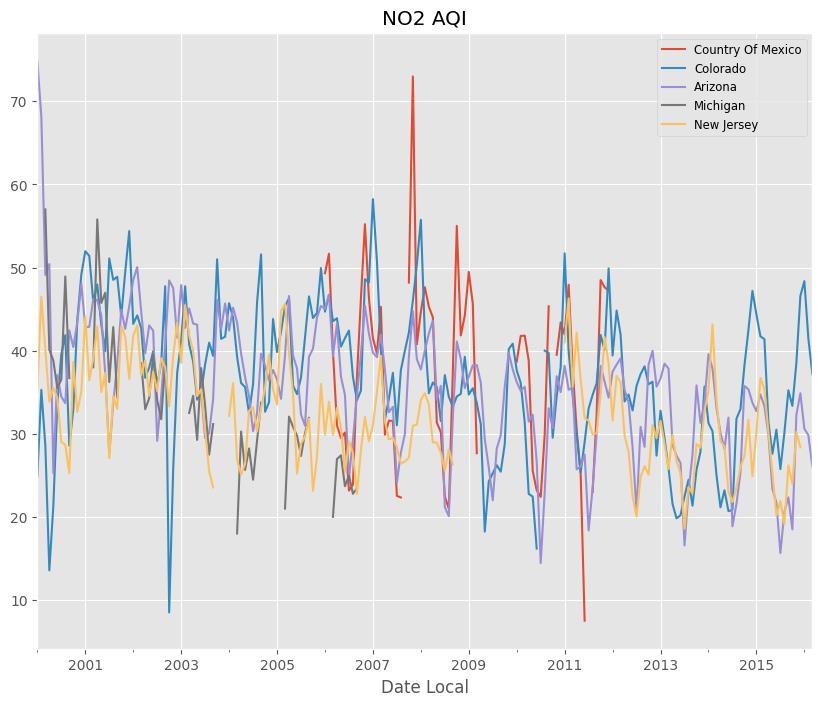

In [36]:
plot_AQI_data(df_AIQ_grouped, column_name="NO2 AQI", number_of_top_state=5)

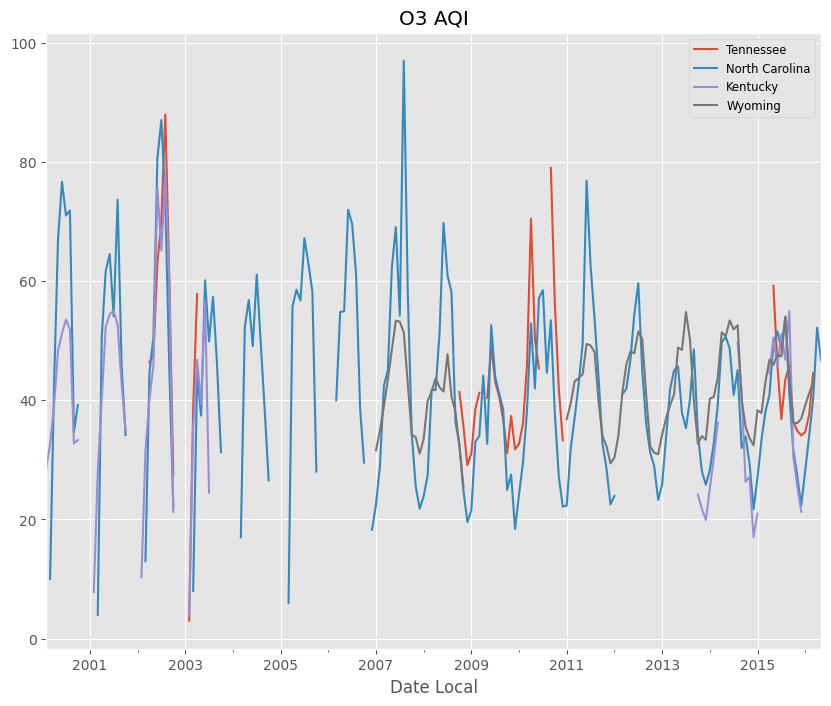

In [37]:
plot_AQI_data(df_AIQ_grouped, column_name="O3 AQI")

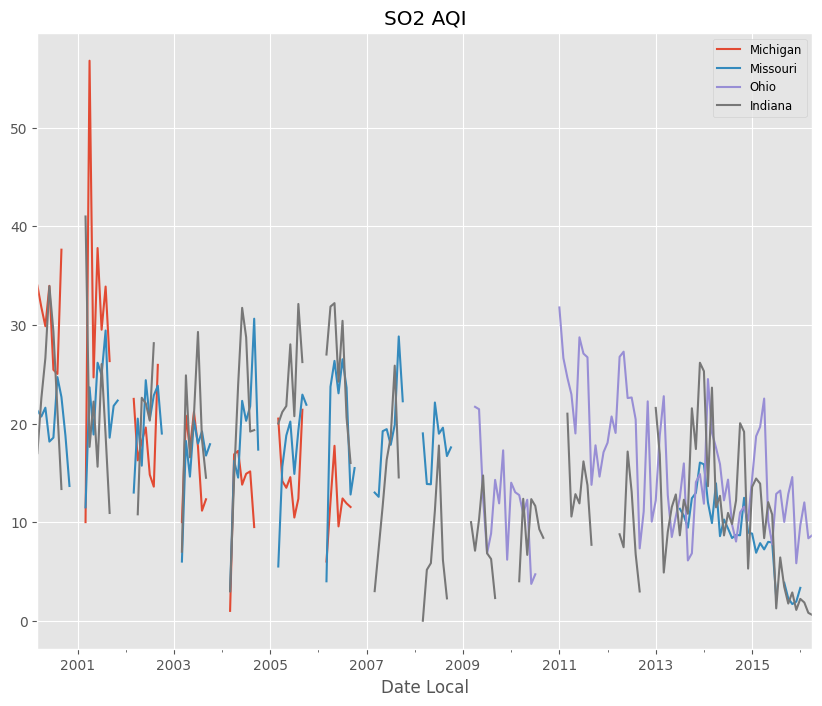

In [38]:
plot_AQI_data(df_AIQ_grouped, column_name="SO2 AQI")

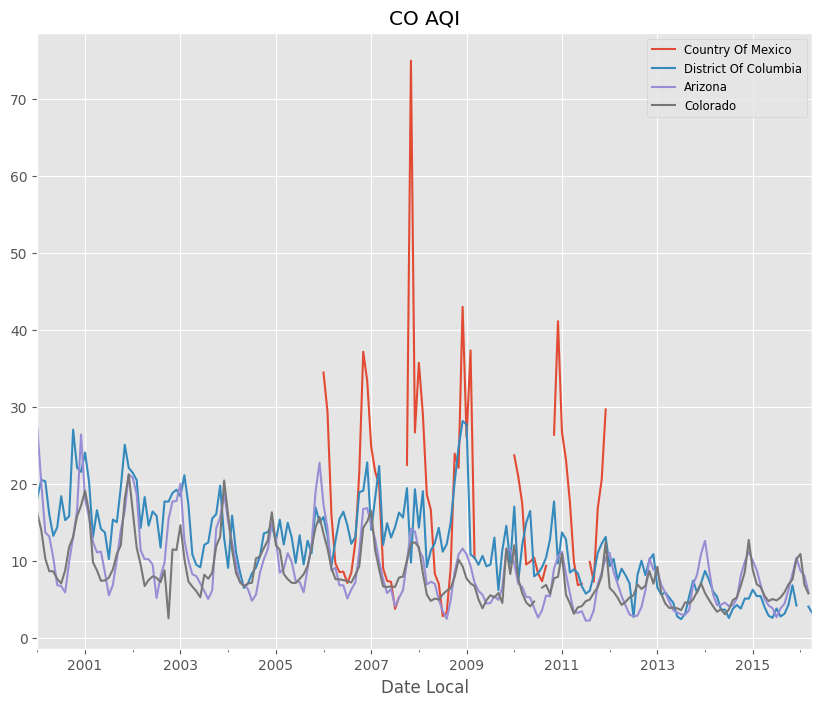

In [39]:
plot_AQI_data(df_AIQ_grouped, column_name="CO AQI")

In [40]:
df_AIQ_NO2 = df_AIQ[["Date Local","NO2 AQI"]]

In [41]:
df_AIQ_NO2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1746661 entries, 0 to 1746660
Data columns (total 2 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Date Local  datetime64[ns]
 1   NO2 AQI     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 26.7 MB


In [42]:
df_AIQ_NO2 = df_AIQ_NO2.set_index("Date Local")

In [43]:
df_AIQ_NO2

,NO2 AQI
Date Local,
2000-01-01,46
2000-01-01,46
2000-01-01,46
2000-01-01,46
2000-01-02,34
...,...
2016-03-30,1
2016-03-31,1
2016-03-31,1


<Axes: title={'center': 'NO2 AQI'}, xlabel='Date Local'>

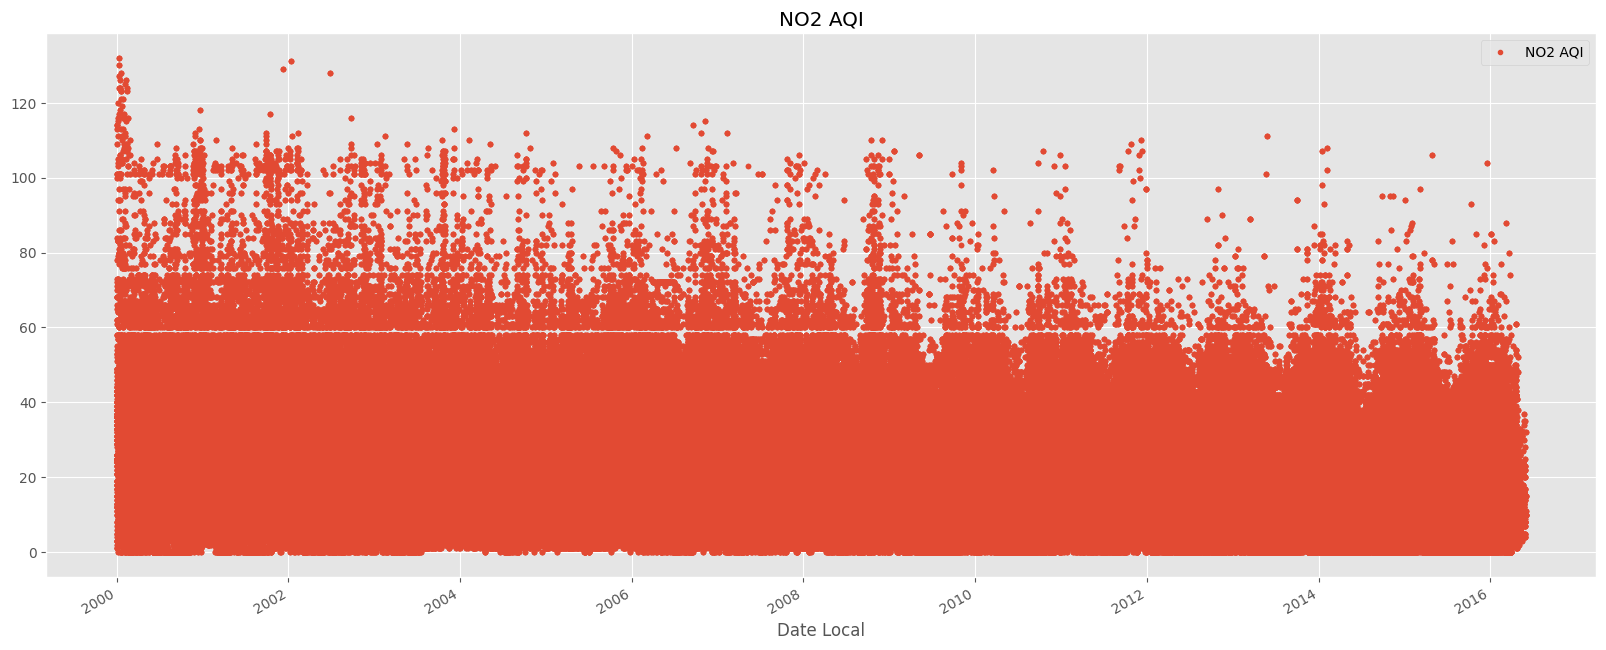

In [44]:
df_AIQ_NO2.plot(style=".", 
                figsize=(20, 8), 
                title="NO2 AQI")

### Time based feature extraction

In [45]:
def create_time_features(df:pd.DataFrame):
    df = df.copy()
    df["day"] = df.index.day
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayOfYear"] = df.index.dayofyear
    return df

In [46]:
df_AIQ_NO2_timefeatures = create_time_features(df_AIQ_NO2)

In [47]:
df_AIQ_NO2_timefeatures

,NO2 AQI,day,month,year,dayOfYear
Date Local,,,,,
2000-01-01,46,1,1,2000,1
2000-01-01,46,1,1,2000,1
2000-01-01,46,1,1,2000,1
2000-01-01,46,1,1,2000,1
2000-01-02,34,2,1,2000,2
...,...,...,...,...,...
2016-03-30,1,30,3,2016,90
2016-03-31,1,31,3,2016,91
2016-03-31,1,31,3,2016,91


In [48]:
df_AIQ_NO2_timefeatures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1746661 entries, 2000-01-01 to 2016-03-31
Data columns (total 5 columns):
 #   Column     Dtype
---  ------     -----
 0   NO2 AQI    int64
 1   day        int32
 2   month      int32
 3   year       int32
 4   dayOfYear  int32
dtypes: int32(4), int64(1)
memory usage: 53.3 MB


## Train Test Split

In [49]:
df_AIQ_NO2_train = df_AIQ_NO2.loc[df_AIQ_NO2.index < "01-01-2014"]
df_AIQ_NO2_test = df_AIQ_NO2.loc[df_AIQ_NO2.index >= "01-01-2014"]

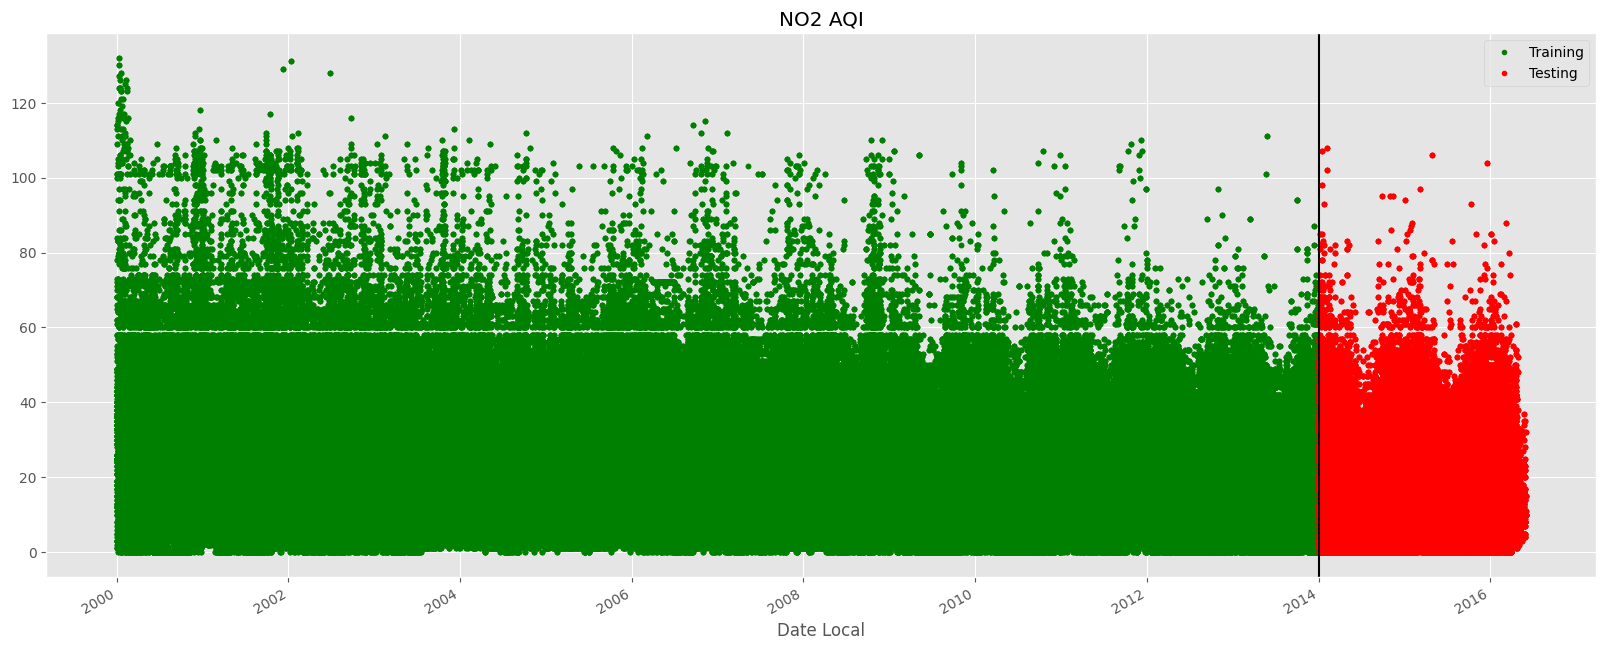

In [50]:
fig, ax = plt.subplots(figsize=(20, 8))

df_AIQ_NO2_train.plot(style=".", ax=ax, label="Training", color="g", title="NO2 AQI")

df_AIQ_NO2_test.plot(style=".", ax=ax, label="Testing", color="r")

ax.axvline("01-01-2014", color="black", ls="-")

ax.legend(["Training", "Testing"])

plt.show()

In [51]:
train_data = create_time_features(df_AIQ_NO2_train)
train_data

,NO2 AQI,day,month,year,dayOfYear
Date Local,,,,,
2000-01-01,46,1,1,2000,1
2000-01-01,46,1,1,2000,1
2000-01-01,46,1,1,2000,1
2000-01-01,46,1,1,2000,1
2000-01-02,34,2,1,2000,2
...,...,...,...,...,...
2013-12-30,13,30,12,2013,364
2013-12-31,1,31,12,2013,365
2013-12-31,1,31,12,2013,365


In [52]:
test_data = create_time_features(df_AIQ_NO2_test)
test_data

,NO2 AQI,day,month,year,dayOfYear
Date Local,,,,,
2014-01-01,44,1,1,2014,1
2014-01-01,44,1,1,2014,1
2014-01-01,44,1,1,2014,1
2014-01-01,44,1,1,2014,1
2014-01-02,7,2,1,2014,2
...,...,...,...,...,...
2016-03-30,1,30,3,2016,90
2016-03-31,1,31,3,2016,91
2016-03-31,1,31,3,2016,91


In [53]:
test_data.columns

Index(['NO2 AQI', 'day', 'month', 'year', 'dayOfYear'], dtype='object')

In [54]:
FEATURES = ['day', 'month', 'year', 'dayOfYear']

LABEL = "NO2 AQI"

Creating `X_train` and `y_train`

In [55]:
X_train = train_data[FEATURES]

y_train = train_data[LABEL]

Creating `X_test` and `y_test`

In [56]:
X_test = test_data[FEATURES]

y_test = test_data[LABEL]

## Forecasting Model

In [57]:
xgb_regressor = xgb.XGBRegressor(n_estimators=1000, 
                                 early_stopping_rounds=50,
                                 learning_rate = 0.01)

In [58]:
xgb_regressor.fit(X_train, 
                  y_train,
                  eval_set = [(X_train, y_train), (X_test, y_test)],
                  verbose=50)

[0]	validation_0-rmse:15.33455	validation_1-rmse:14.30171
[50]	validation_0-rmse:14.74701	validation_1-rmse:13.43597
[100]	validation_0-rmse:14.51011	validation_1-rmse:13.01695
[150]	validation_0-rmse:14.40952	validation_1-rmse:12.81356
[200]	validation_0-rmse:14.36183	validation_1-rmse:12.72042
[250]	validation_0-rmse:14.33532	validation_1-rmse:12.68409
[300]	validation_0-rmse:14.31806	validation_1-rmse:12.66942
[350]	validation_0-rmse:14.30466	validation_1-rmse:12.66974
[380]	validation_0-rmse:14.29789	validation_1-rmse:12.67443


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importance

In [59]:
feature_importance = pd.DataFrame(data=xgb_regressor.feature_importances_,
                                  index=xgb_regressor.feature_names_in_,
                                  columns=["Importance"])

In [60]:
feature_importance

,Importance
day,0.018735
month,0.581711
year,0.257686
dayOfYear,0.141868


<Axes: title={'center': 'Feature Importance'}>

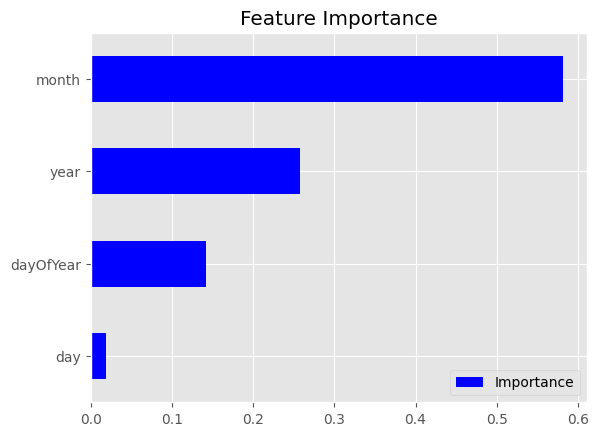

In [61]:
feature_importance.sort_values("Importance").plot(kind="barh", 
                                                  title="Feature Importance",
                                                  color="b")

### Prediction

In [62]:
test_data["xgb_forecasting"] = xgb_regressor.predict(X_test)

In [63]:
test_data

,NO2 AQI,day,month,year,dayOfYear,xgb_forecasting
Date Local,,,,,,
2014-01-01,44,1,1,2014,1,21.614931
2014-01-01,44,1,1,2014,1,21.614931
2014-01-01,44,1,1,2014,1,21.614931
2014-01-01,44,1,1,2014,1,21.614931
2014-01-02,7,2,1,2014,2,23.037954
...,...,...,...,...,...,...
2016-03-30,1,30,3,2016,90,20.793118
2016-03-31,1,31,3,2016,91,18.907494
2016-03-31,1,31,3,2016,91,18.907494


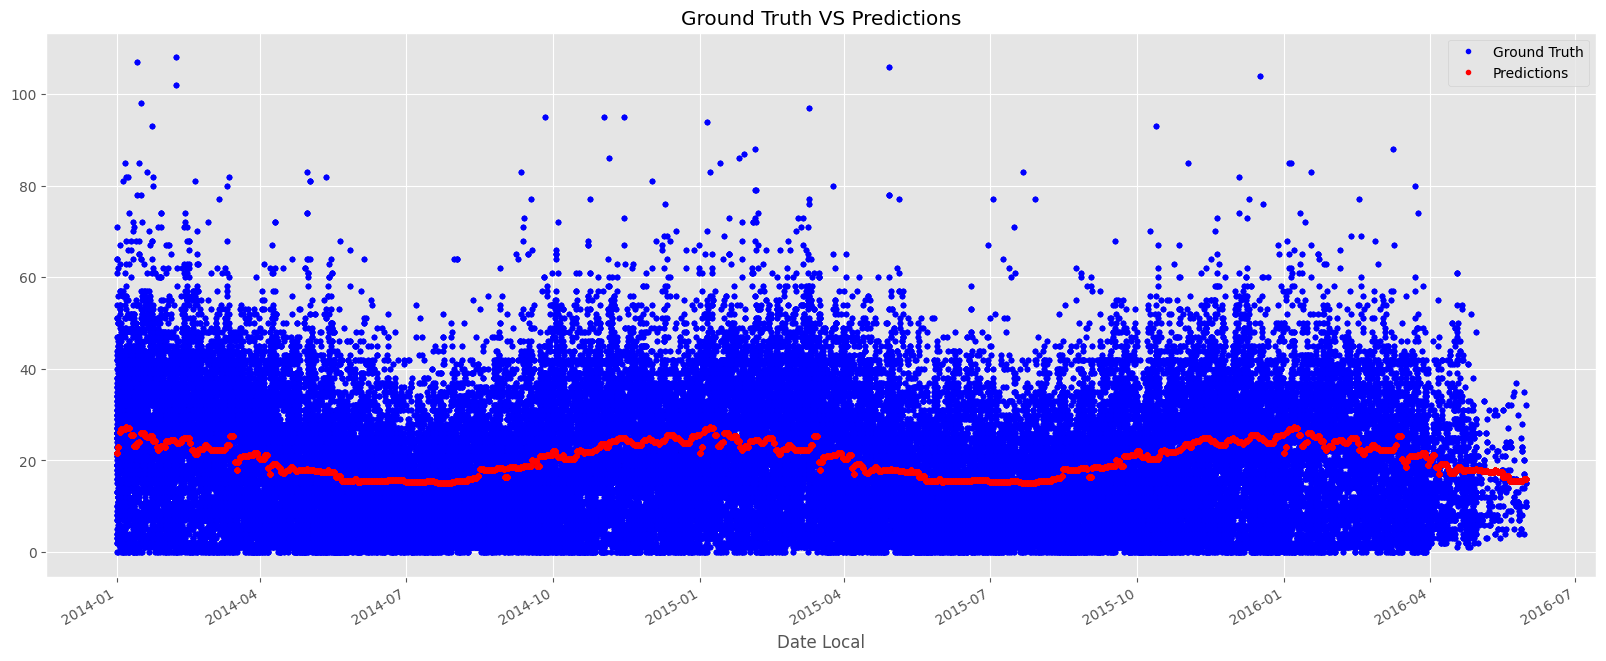

In [64]:
ax = test_data[["NO2 AQI"]].plot(figsize=(20, 8), style=".", color="b")
test_data["xgb_forecasting"].plot(ax=ax, style=".", color="r")
plt.legend(["Ground Truth", "Predictions"])
plt.title("Ground Truth VS Predictions")
plt.show()

Evaluation Matrix

`MSE` and `RMSE`

In [65]:
def generate_mse_and_rmse(label_column_name, ):
    mse_result = mean_squared_error(test_data["NO2 AQI"], test_data["xgb_forecasting"])
    print(f"MSE: {mse_result:0.2f}")
    rmse_result = np.sqrt(mse_result)
    print(f"RMSE: {rmse_result:0.2f}")

In [66]:
test_data["error"] = np.abs(test_data["NO2 AQI"] - test_data["xgb_forecasting"])
test_data["date"] = test_data.index.date

In [67]:
test_data

,NO2 AQI,day,month,year,dayOfYear,xgb_forecasting,error,date
Date Local,,,,,,,,
2014-01-01,44,1,1,2014,1,21.614931,22.385069,2014-01-01
2014-01-01,44,1,1,2014,1,21.614931,22.385069,2014-01-01
2014-01-01,44,1,1,2014,1,21.614931,22.385069,2014-01-01
2014-01-01,44,1,1,2014,1,21.614931,22.385069,2014-01-01
2014-01-02,7,2,1,2014,2,23.037954,16.037954,2014-01-02
...,...,...,...,...,...,...,...,...
2016-03-30,1,30,3,2016,90,20.793118,19.793118,2016-03-30
2016-03-31,1,31,3,2016,91,18.907494,17.907494,2016-03-31
2016-03-31,1,31,3,2016,91,18.907494,17.907494,2016-03-31


Best Predictions

In [68]:
test_data.groupby(["date"])["error"].mean().sort_values(ascending=True).head(10)

date
2016-05-16    3.651514
2016-05-23    4.249448
2016-05-21    5.116240
2016-05-19    5.229536
2016-05-03    5.411047
2016-05-25    5.488279
2016-05-26    5.727110
2016-05-31    5.747124
2016-05-02    5.865336
2016-05-17    6.069222
Name: error, dtype: float64

Worst Prediction

In [69]:
test_data.groupby(["date"])["error"].mean().sort_values(ascending=False).head(10)

date
2016-04-18    15.816400
2015-03-09    15.459909
2015-03-10    15.449016
2016-01-23    15.448517
2014-02-14    15.055467
2014-02-13    14.897613
2015-03-16    14.748935
2015-03-08    14.740276
2014-10-03    14.678578
2014-03-11    14.605033
Name: error, dtype: float64

  ### Feature Engineering

Extract features day, month and year of the data

#### Maintaining the data sequence and consistency using `TimeSeriesSplit`

### Prevention on data leakage in time series data

## ML Modeling

### Forecasting

### Clasification